In [2]:
from qutip import basis, qeye, tensor, destroy, thermal_dm, mesolve, steadystate, Options, entropy_mutual
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from utils import *
import phonons as RC
from style import *
import optical as EM
import time


XO = basis(2,0) # higher in energy
OX = basis(2,1) # lower in energy

sigma = OX*XO.dag()

I_sys = qeye(2)
initial_sys = sigma.dag()*sigma #0.5*(E+G)*(G.dag()+E.dag())
T_EM = 0.
reload(RC)
reload(EM)
sigma_x = sigma + sigma.dag()
sigma_z =  sigma.dag()*sigma - sigma*sigma.dag()

In [3]:
T_ph = 100.
#data_dimer_wc =  load_obj('DATA/data_wc_'+str(T_ph))
#data_dimer_sc =  load_obj('DATA/data_sc_'+str(T_ph))
#H = load_obj('DATA/H_'+str(T_ph))
H = load_obj('DATA/H_300')
H_dimer = H[0]
H_dimer = H_dimer.eliminate_states([0])
#timelist = np.linspace(0, 1.8, 1500)
timelist = np.linspace(0, 8., 2500)
print H_dimer
epsilon = (H_dimer.full()[0][0]-H_dimer.full()[1][1])
H_RF = epsilon*sigma_z + H_dimer.full()[1][0]*sigma_x
print H_RF

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1051.57079633   50.        ]
 [  50.         1001.57079633]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 50.  50.]
 [ 50. -50.]]


In [8]:
reload(RC)
def plot_dynamics(timelist, data_1, data_2, A_EM, A_ph, ss, timelength=1, labels = ['full', 'add.']):
    linestyles = ['solid', 'solid']
    data_list = [data_1, data_2]
    alphas = [1, 0.5]
    f, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(4, 1, figsize=(12,12), sharex=True)
    for i, data in enumerate(data_list):
        l, c, linestyle, a = labels[i], colourWheel[i], linestyles[i], alphas[i]
        if l =='WC':
            A_EM, A_ph = sigma, 0.
        ax1.plot(timelist, data.expect[1].real, label=l, color=c, ls=linestyle, alpha=a) # TLS pop.
        ax1.axhline((ss[i]*A_EM.dag()*A_EM).tr().real, color=c, ls='dotted')
        ax2.plot(timelist, data.expect[2].real, label=l, color=c, ls=linestyle, alpha=a) # sigma_x
        ax2.axhline((ss[i]*(A_EM.dag()+A_EM)).tr().real, color=c, ls='dotted')
        ax3.plot(timelist, data.expect[3].real, label=l, color=c, ls=linestyle, alpha=a) # Real eig
        #ax3.axhline(data.expect[3].real.real[-1], color=c, ls='dotted')
        ax4.plot(timelist, data.expect[4].real, label=l, color=c, ls=linestyle, alpha=a) # TLS current
        #ax4.axhline(data.expect[4].real[-1], color=c, ls='dotted')
    ax1.set_ylabel(r'$\langle\sigma^{\dagger}\sigma\rangle$')
    ax2.set_ylabel(r'$\langle\sigma_x\rangle$')
    ax3.set_ylabel(r'$2\Re\langle |+\rangle\!\langle -|\rangle$')
    ax4.set_ylabel(r'$\langle I_{g \to e} \rangle$')
    #ax4.set_ylabel(r'$2\Im\langle |+\rangle\!\langle -|\rangle$')
    ax4.set_xlabel('Time')
    ax1.legend(loc='best')
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(timelist[0], timelist[int((len(timelist)-1)*timelength)])
        ax.set_aspect('auto')
    plt.show()

def weak_phonon(H_sub, alpha=0., w_0=0., Gamma=0., T=0.):
    A = sigma_z
    return EM.L_non_rwa(H_sub, A, w_0, Gamma, T, J_underdamped, 
                     principal=True, silent=True, alpha=alpha) # need principal value parts

def thermal_state(H, T):
    _Th = (-beta_f(T)*H_RF).expm()
    return _Th/_Th.tr()

def WC_comparison():
    w_laser = 0.
    alpha_ph = 0.1
    alpha_EM = 0. #5.309e-3 # inv_ps_to_inv_cm *10^-3
    N =5
    wc = 50.
    w0 = 500.
    Gamma = (w0**2)/wc
    #H_sub = H_dimer
    #H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
    #print H_sub
    print w0, alpha_ph, Gamma
    energies, states = H_RF.eigenstates()
    real_exciton = (states[1]*states[0].dag() + states[0]*states[1].dag())
    imag_exciton = 1j*(states[1]*states[0].dag() - states[0]*states[1].dag())
    
    L_RC, H, A_EM, A_ph, Z, wRC, kappa, gamma = RC.RC_mapping_general(H_RF, sigma, T_ph, Gamma, 
                                                                        w0, alpha_ph, N,
                                                                        silent=False, w_laser=w_laser, 
                                                                      shift=False, shift_op=-sigma_z)
    L, L_wc = L_RC, 0
    ss, data = [], []
    options = Options(nsteps=1500, store_states=True)
    for i, l in enumerate(['full', 'WC']):
        if l =='full':
            n_RC = EM.Occupation(w0, T_ph)
            I = qeye(N)
            rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
            expects = [tensor(sigma*sigma.dag(), I), tensor(sigma.dag()*sigma, I), tensor(sigma_x, I), #0, 1, 2
                        tensor(real_exciton, I), tensor(imag_exciton, I)]
            #ss.append(steadystate(H, [L_RC]))
            data.append(mesolve(H, rho_0, timelist, c_ops=[L_RC], e_ops=expects, options=options))
        else:
            expects = [sigma*sigma.dag(), sigma.dag()*sigma, sigma_x, #0, 1, 2
                       real_exciton, imag_exciton] # 4, 5
            
            L_wc = weak_phonon(H_RF, alpha=alpha_ph, 
                               w_0=w0, Gamma=Gamma, T=T_ph)
            #print L_wc, L_wc2
            #L_wc += EM.L_nonsecular(H_sub, sigma, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
            rho_0 = initial_sys
            data.append(mesolve(H_RF, rho_0, timelist, c_ops=[L_wc], e_ops=expects, options=options))  
            
    #print "Full:\n", ss[0].ptrace(0).full(), '\n Add.:\n', ss[1].ptrace(0).full()
    print("Dynamics complete")
    return timelist, data[0], data[1], L_RC, H, A_ph, A_EM, ss

In [9]:
timelist, data_rf_full, data_rf_wc, L_RC, H, A_ph, A_EM, ss = WC_comparison()


500.0 0.1 5000.0
w_RC=500.0 | RC-res. coupling=1.5915 | TLS-RC coupling=8.86 | Gamma_RC=5000.00 | alpha_ph=0.10 | N=5 |
shit is  0.0
Integral converged to 0.157076213385 with step size of 200.0
Integral converged to 0.0745159024219 with step size of 200.0
Integral converged to -0.16581019023 with step size of 100.0
Integral converged to -0.132374804981 with step size of 100.0
Integral converged to 0.173298014352 with step size of 200.0
Integral converged to 0.157076213385 with step size of 200.0
Dynamics complete


0.0015560382012818348
0.0015560382006590222
0.0060138444229415715


/Users/henrymaguire/.pyenv/versions/2.7.15/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


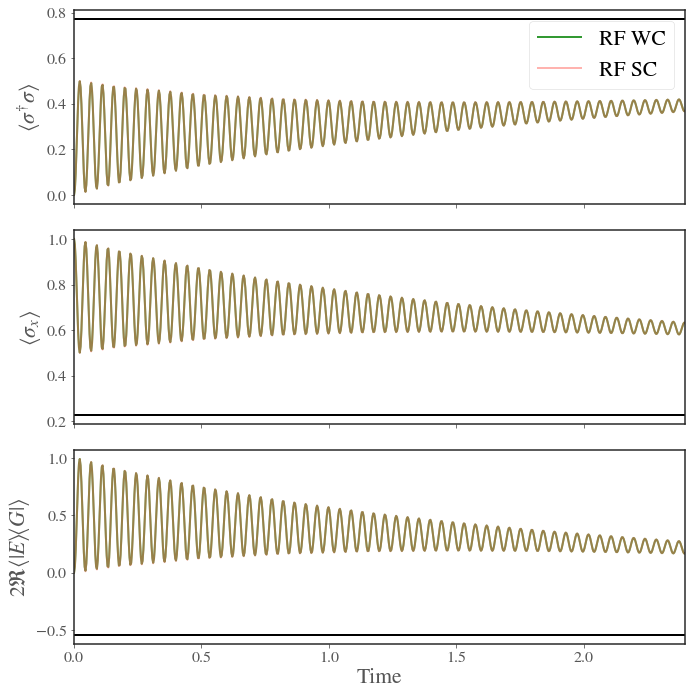

NOW CROSS COMPARISONS


"compare_dynamics(timelist,  data_rf_wc, data_dimer_sc, A_EM, A_ph, ss, timelength=1, labels = ['RF WC', 'Dimer SC'])\ncompare_dynamics(timelist,  data_rf_full, data_dimer_sc, A_EM, A_ph, ss, timelength=1, labels = ['RF SC', 'Dimer SC'])\ncompare_dynamics(timelist,  data_rf_full, data_dimer_wc, A_EM, A_ph, ss, timelength=1, labels = ['RF SC', 'Dimer WC'])\ncompare_dynamics(timelist,  data_rf_wc, data_dimer_wc, A_EM, A_ph, ss, timelength=1, labels = ['RF WC', 'Dimer WC'])\n"

In [10]:
def compare_dynamics(timelist, data_1, data_2, A_EM, A_ph, ss, timelength=1, labels = ['full', 'add.']):
    linestyles = ['solid', 'solid']
    data_list = [data_1, data_2]
    alphas = [1, 0.5]
    f, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(10,10), sharex=True)
    S_th = thermal_state(H_RF, T_ph)
    for i, data in enumerate(data_list):
        l, c, linestyle, a = labels[i], colourWheel[i], linestyles[i], alphas[i]
        if l =='WC':
            A_EM, A_ph = sigma, 0.
        ax1.plot(timelist, data.expect[0].real, label=l, color=c, ls=linestyle, alpha=a) # TLS pop.
        ax2.plot(timelist, data.expect[1].real, label=l, color=c, ls=linestyle, alpha=a) # sigma_x
        ax3.plot(timelist, data.expect[2].real, label=l, color=c, ls=linestyle, alpha=a) # Real eig
        ax3.axhline((S_th*sigma_x).tr(), color='k')
        ax1.axhline((S_th*sigma*sigma.dag()).tr(), color='k')
        ax2.axhline((S_th*sigma.dag()*sigma).tr(), color='k')
    for i in range(3):
        print sum((data_1.expect[i].real-data_2.expect[i].real)**2)
    ax1.set_ylabel(r'$\langle\sigma^{\dagger}\sigma\rangle$')
    ax2.set_ylabel(r'$\langle\sigma_x\rangle$')
    ax3.set_ylabel(r'$2\Re\langle |E\rangle\!\langle G|\rangle$')
    ax3.set_xlabel('Time')
    ax1.legend(loc='best')
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(timelist[0], timelist[int((len(timelist)-1)*timelength)])
        ax.set_aspect('auto')
    plt.show()
    
compare_dynamics(timelist,  data_rf_wc, data_rf_full, A_EM, A_ph, ss, timelength=0.3, labels = ['RF WC', 'RF SC'])
#compare_dynamics(timelist,  data_dimer_wc, data_dimer_sc, A_EM, A_ph, ss, timelength=1, labels = ['Dimer WC', 'Dimer SC'])
print "NOW CROSS COMPARISONS"
"""compare_dynamics(timelist,  data_rf_wc, data_dimer_sc, A_EM, A_ph, ss, timelength=1, labels = ['RF WC', 'Dimer SC'])
compare_dynamics(timelist,  data_rf_full, data_dimer_sc, A_EM, A_ph, ss, timelength=1, labels = ['RF SC', 'Dimer SC'])
compare_dynamics(timelist,  data_rf_full, data_dimer_wc, A_EM, A_ph, ss, timelength=1, labels = ['RF SC', 'Dimer WC'])
compare_dynamics(timelist,  data_rf_wc, data_dimer_wc, A_EM, A_ph, ss, timelength=1, labels = ['RF WC', 'Dimer WC'])
"""

In [ ]:
from qutip.nonmarkov.heom import HSolverDL
hsolver = HSolverDL(H_RF, sigma_z, lam, temperature, Ncut, Nk, gam, stats=True)

2.1812195680411057
2.18121956804599
8.462164071243443


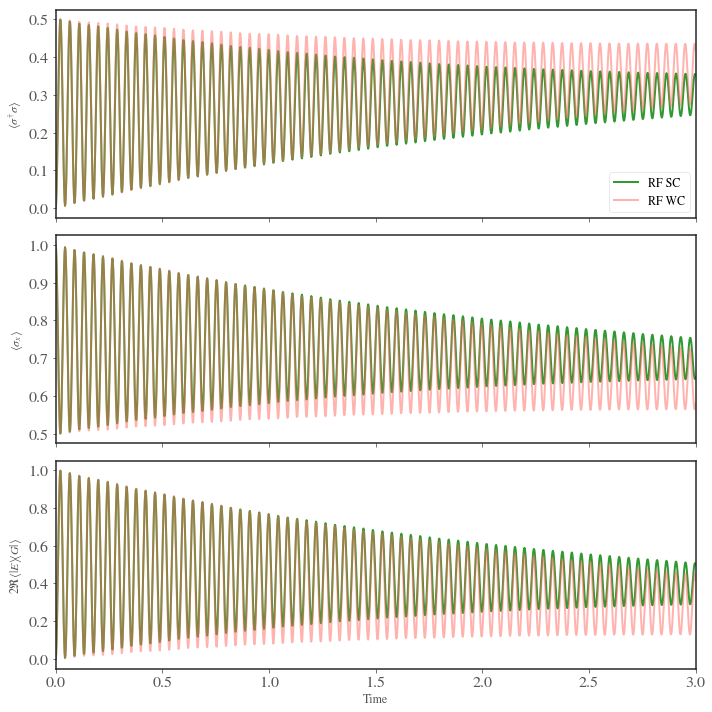

In [129]:
compare_dynamics(timelist,  data_rf_full, data_rf_wc, A_EM, A_ph, ss, timelength=1, labels = ['RF SC', 'RF WC'])

2.1812195680411057
2.18121956804599
8.462164071243443


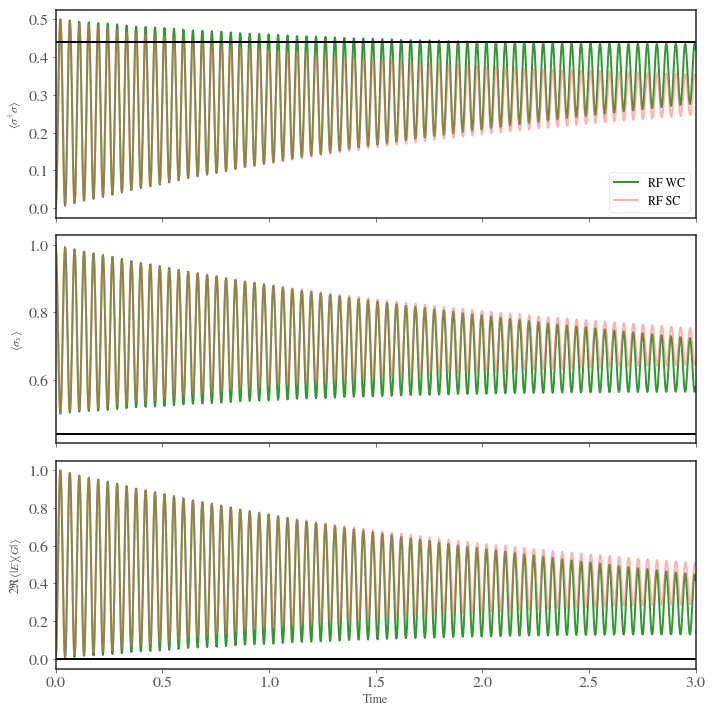

2.6078447520541914
2.607844752053662
16.825325086580303


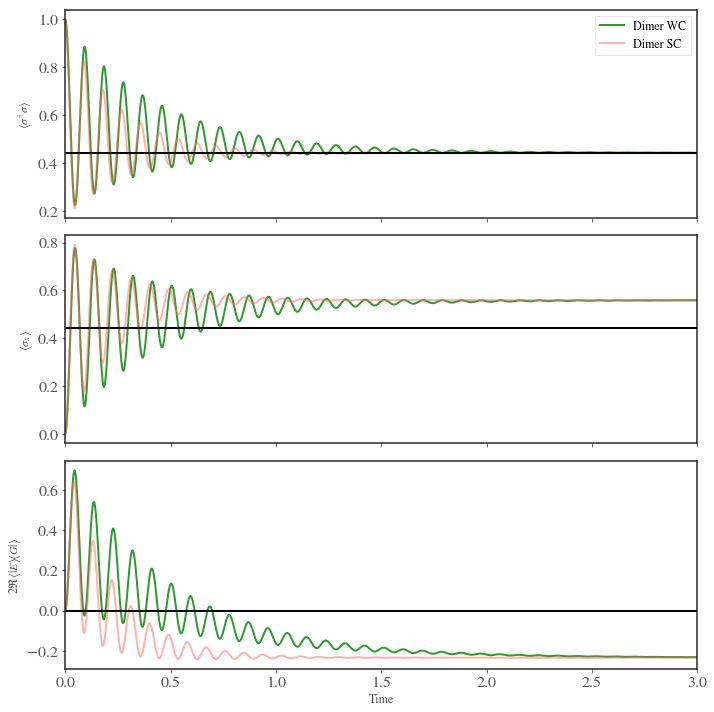

59.6162504058926
59.61625040589204
596.4100779959771


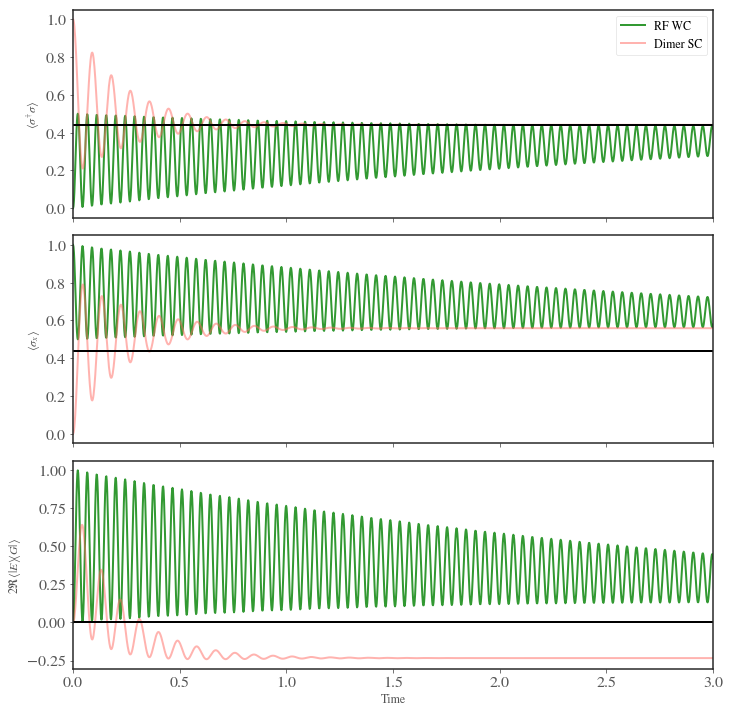

68.38162581588868
68.38162581590731
691.1109359364885


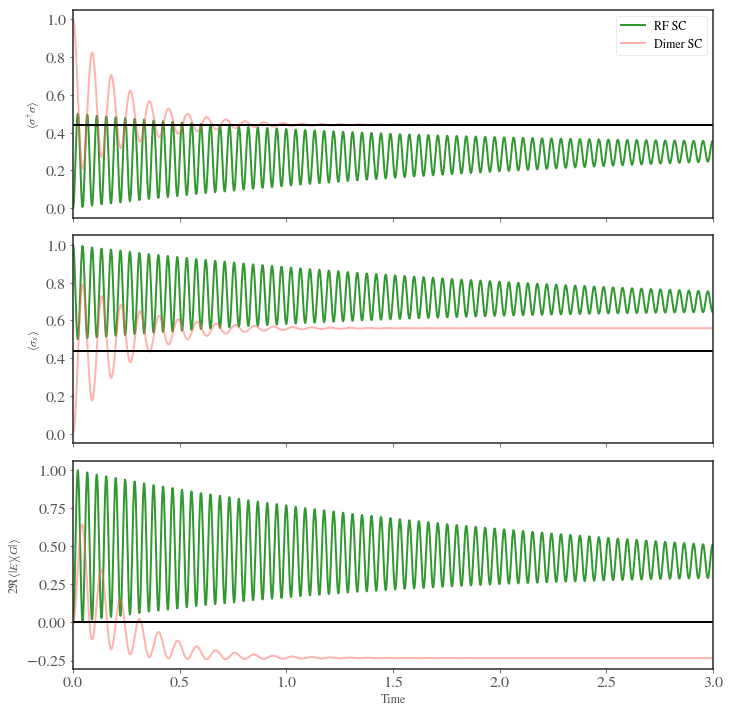

82.51021766679924
82.51021766680968
576.7607263543928


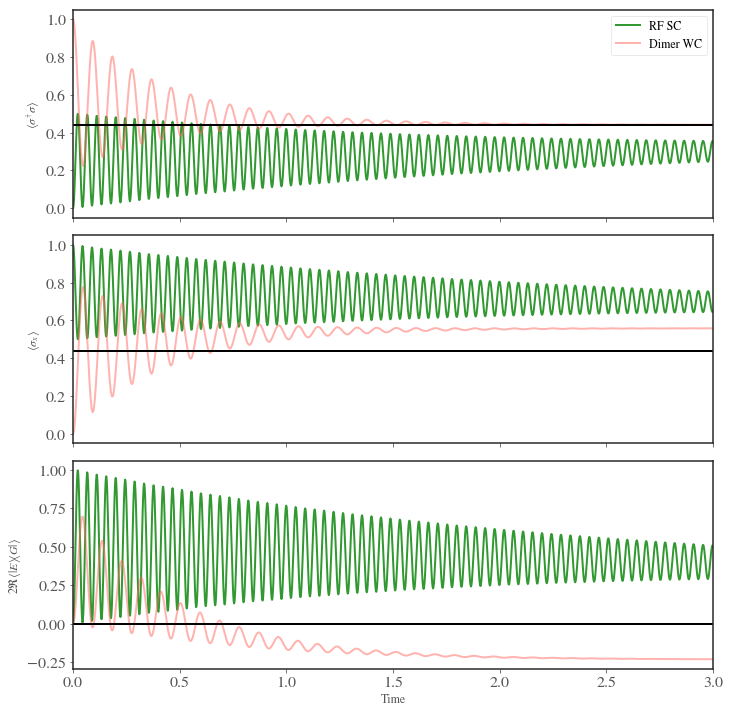

72.94213390249932
72.94213390249122
488.4548675565972


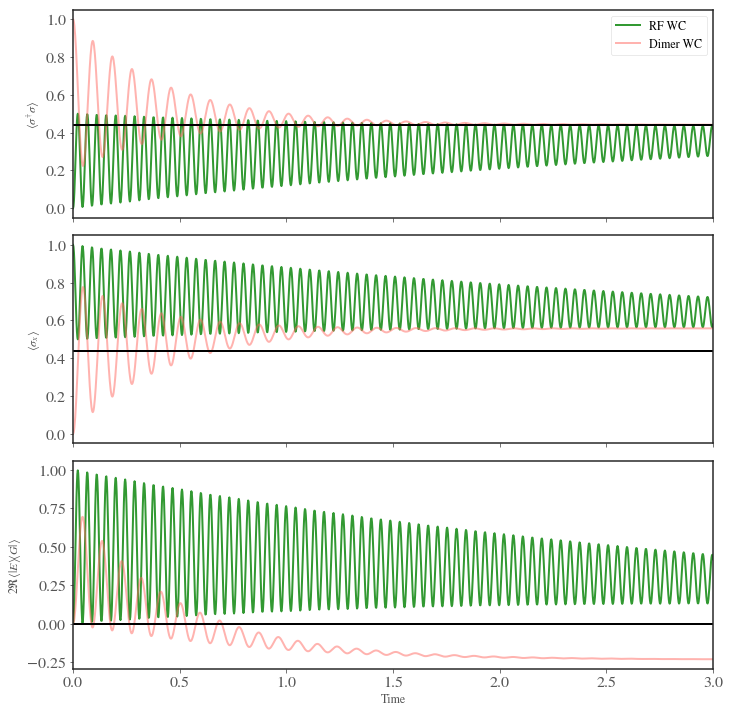

In [134]:
def compare_dynamics(timelist, data_1, data_2, A_EM, A_ph, ss, timelength=1, labels = ['full', 'add.']):
    linestyles = ['solid', 'solid']
    data_list = [data_1, data_2]
    alphas = [1, 0.5]
    S_th = thermal_dm(2, EM.Occupation(epsilon, T_ph).real)
    f, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(10,10), sharex=True)
    for i, data in enumerate(data_list):
        l, c, linestyle, a = labels[i], colourWheel[i], linestyles[i], alphas[i]
        if l =='WC':
            A_EM, A_ph = sigma, 0.
        ax1.plot(timelist, data.expect[0].real, label=l, color=c, ls=linestyle, alpha=a) # TLS pop.
        
        ax2.plot(timelist, data.expect[1].real, label=l, color=c, ls=linestyle, alpha=a) # sigma_x
        ax3.axhline((S_th*sigma_x).tr(), color='k')
        ax1.axhline((S_th*sigma*sigma.dag()).tr(), color='k')
        ax2.axhline((S_th*sigma*sigma.dag()).tr(), color='k')
        ax3.plot(timelist, data.expect[2].real, label=l, color=c, ls=linestyle, alpha=a) # Real eig
        
    for i in range(3):
        print sum((data_1.expect[i].real-data_2.expect[i].real)**2)
    ax1.set_ylabel(r'$\langle\sigma^{\dagger}\sigma\rangle$')
    ax2.set_ylabel(r'$\langle\sigma_x\rangle$')
    ax3.set_ylabel(r'$2\Re\langle |E\rangle\!\langle G|\rangle$')
    ax3.set_xlabel('Time')
    ax1.legend(loc='best')
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(timelist[0], timelist[int((len(timelist)-1)*timelength)])
        ax.set_aspect('auto')
    plt.show()
    
compare_dynamics(timelist,  data_rf_wc, data_rf_full, A_EM, A_ph, ss, timelength=1, labels = ['RF WC', 'RF SC'])
compare_dynamics(timelist,  data_dimer_wc, data_dimer_sc, A_EM, A_ph, ss, timelength=1, labels = ['Dimer WC', 'Dimer SC'])
compare_dynamics(timelist,  data_rf_wc, data_dimer_sc, A_EM, A_ph, ss, timelength=1, labels = ['RF WC', 'Dimer SC'])
compare_dynamics(timelist,  data_rf_full, data_dimer_sc, A_EM, A_ph, ss, timelength=1, labels = ['RF SC', 'Dimer SC'])
compare_dynamics(timelist,  data_rf_full, data_dimer_wc, A_EM, A_ph, ss, timelength=1, labels = ['RF SC', 'Dimer WC'])
compare_dynamics(timelist,  data_rf_wc, data_dimer_wc, A_EM, A_ph, ss, timelength=1, labels = ['RF WC', 'Dimer WC'])


MOst matching is the RF WC with dimer SC. Then RF SC with the dimer WC. Then the dimer SC with RF WC. What could be causing this? WC and SC are likely to be out of phase relative to each other ever so slightly. Perhaps the WC should not use 

In [ ]:
def RF_dimer_comparison(timelist, rf_wc, rf_sc, dimer_wc, dimer_sc, timelength=1, 
                        labels = ['rf sc', 'rf wc', 'dimer wc', 'dimer sc']):
    linestyles = ['solid']*4
    data_list = [rf_wc, rf_sc, dimer_wc, dimer_sc]
    alphas = [1, 0.5, 1, 0.5]
    f, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(12,12), sharex=True)
    for i, data in enumerate(data_list):
        l, c, linestyle, a = labels[i], colourWheel[i], linestyles[i], alphas[i]
        if l =='WC':
            A_EM, A_ph = sigma, 0.
        ax1.plot(timelist, data.expect[0].real, label=l, color=c, ls=linestyle, alpha=a) # TLS pop.
        ax2.plot(timelist, data.expect[1].real, label=l, color=c, ls=linestyle, alpha=a) # sigma_x
        ax3.plot(timelist, data.expect[2].real, label=l, color=c, ls=linestyle, alpha=a) # Real eig
        #ax4.axhline(data.expect[4].real[-1], color=c, ls='dotted')
    ax1.set_ylabel(r'$\langle\sigma^{\dagger}\sigma\rangle$')
    ax2.set_ylabel(r'$\langle\sigma_x\rangle$')
    ax3.set_ylabel(r'$2\Re\langle |+\rangle\!\langle -|\rangle$')
    #ax4.set_ylabel(r'$2\Im\langle |+\rangle\!\langle -|\rangle$')
    ax3.set_xlabel('Time')
    ax1.legend(loc='best')
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(timelist[0], timelist[int((len(timelist)-1)*timelength)])
        ax.set_aspect('auto')
    plt.show()
    
RF_dimer_comparison(timelist,   data_rf_wc, data_rf_full,  data_dimer_wc, data_dimer_sc,
                    timelength=1, labels = ['rf sc', 'rf wc', 'dimer wc', 'dimer sc'])



In [24]:
timelist,  data_rf_full, data_rf_wc,

(array([0.00000000e+00, 1.20080053e-03, 2.40160107e-03, ...,
        1.79759840e+00, 1.79879920e+00, 1.80000000e+00]),
 Result object with mesolve data.
 --------------------------------
 states = True
 num_collapse = 0,
 Result object with mesolve data.
 --------------------------------
 states = True
 num_collapse = 0)